In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice

C:\Users\Modeller\AppData\Local\anaconda3\envs\summary\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C',
          '#BFE9E7','#7a2700']
sns.set(font="Pragmatica")

In [3]:
df = pd.read_csv(r'..\..\..\outputs\network\network_results.csv')

# Congested network components by time of day
df.columns

# Get freeflow from 20to5 period

# Exclude trips taken on non-designated facilities (facility_type == 0)
# These are artificial (weave lanes to connect HOV) or for non-auto uses 
df = df[df['data3'] != 0]    # data3 represents facility_type

# calculate total link VMT and VHT
df['VMT'] = df['@tveh']*df['length']
df['VHT'] = df['@tveh']*df['auto_time']/60

# Define facility type
df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

# Calculate delay
# Select links from overnight time of day
delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

# Merge delay field back onto network link df
df = pd.merge(df, delay_df, on='ij', how='left')

# Calcualte hourly delay
df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

# Calcualte speed as a percent of freeflow
df['flow_index'] = df['auto_time']/df['freeflow_time']

df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})

# FGTS

# Non-motorized extent in geographies

# High Capacity Transit Network

In [4]:
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

# Congestion by County Tables
### Total VMT & Percent of County VMT by Congestion Level

- **Severe: < 25% Speed Limit** (e.g., less than 15 mph on a road with speed limit of 60 mph)
- **Heavy: 25-50% Speed Limit** (e.g., 15-30 mph on a road with speed limit of 60 mph)
- **Moderate: 50-70% Speed Limit** (e.g, 30-42 mph on a road with speed limit of 60 mph)

#### All Day

In [5]:
# Percent of VMT by congestion category
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"35,610,836","4,111,702","16,261,300","14,783,943"
Moderate,"4,838,755","89,510","1,712,034","1,130,495"
Heavy,"2,552,148","49,754","620,062","505,749"
Severe,"263,108","5,030","37,295","78,894"


In [6]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,82.3%,96.6%,87.3%,89.6%
Moderate,11.2%,2.1%,9.2%,6.9%
Heavy,5.9%,1.2%,3.3%,3.1%
Severe,0.6%,0.1%,0.2%,0.5%


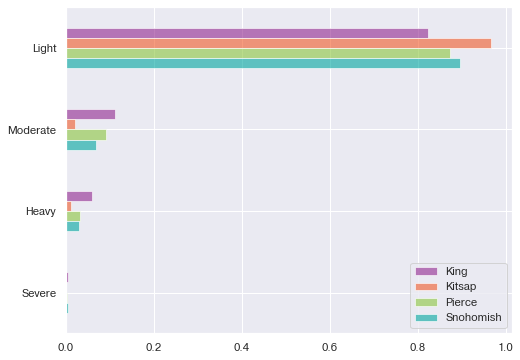

In [7]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

**Freeway** VMT by Congestion Category

In [8]:
# Segment by facility type
_df = df[df['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"17,903,987","1,659,067","6,770,853","6,887,852"
Moderate,"3,093,587","15,406","905,049","595,638"
Heavy,"1,645,213","6,574","279,207","150,123"
Severe,"82,365",341,"1,576","12,187"


**Arterial** VMT by Congestion Category

In [9]:
# Segment by facility type
_df = df[df['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"15,340,896","2,021,853","8,080,632","6,474,961"
Moderate,"1,745,019","74,104","806,985","534,856"
Heavy,"906,915","43,180","340,855","355,626"
Severe,"180,736","4,690","35,719","66,706"


#### AM Peak (7 to 8 AM)

In [10]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,161,284","298,252","998,593","943,449"
Moderate,"575,263","6,402","252,949","183,294"
Heavy,"498,182","8,957","139,433","72,677"
Severe,"41,455",385,"4,273","10,684"


In [11]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,66.0%,95.0%,71.6%,78.0%
Moderate,17.6%,2.0%,18.1%,15.1%
Heavy,15.2%,2.9%,10.0%,6.0%
Severe,1.3%,0.1%,0.3%,0.9%


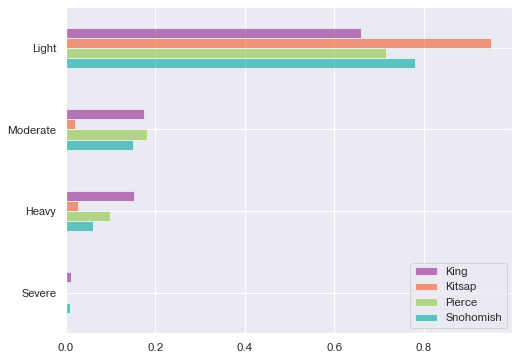

In [12]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

AM Peak **Freeway** VMT

In [13]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"942,202","132,193","350,625","427,610"
Moderate,"388,252","1,046","171,010","132,041"
Heavy,"394,808","5,775","102,128","37,864"
Severe,"21,279",0,285,519


AM Peak **Arterial** VMT

In [14]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,076,937","141,600","563,810","431,983"
Moderate,"186,972","5,356","81,939","51,253"
Heavy,"103,374","3,182","37,305","34,813"
Severe,"20,176",385,"3,988","10,165"


#### PM Peak (5 to 6 PM)

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
df_pm = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,161,284","298,252","998,593","943,449"
Moderate,"575,263","6,402","252,949","183,294"
Heavy,"498,182","8,957","139,433","72,677"
Severe,"41,455",385,"4,273","10,684"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,66.0%,95.0%,71.6%,78.0%
Moderate,17.6%,2.0%,18.1%,15.1%
Heavy,15.2%,2.9%,10.0%,6.0%
Severe,1.3%,0.1%,0.3%,0.9%


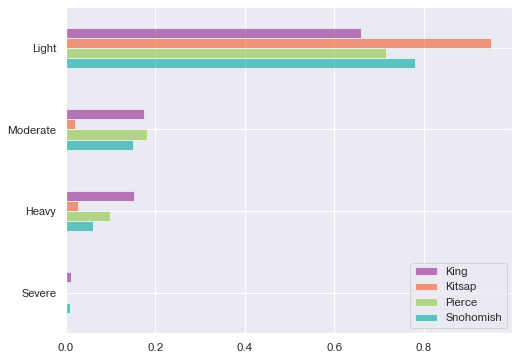

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

PM **Freeway** VMT

In [18]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,026,865","134,614","381,595","452,529"
Moderate,"414,856","4,774","189,125","121,323"
Heavy,"315,171",0,"53,712","31,096"
Severe,"21,574",170,508,"1,216"


PM **Arterial** VMT

In [19]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,250,937","164,691","646,395","501,970"
Moderate,"218,833","5,953","95,503","64,727"
Heavy,"115,281","4,589","42,747","45,576"
Severe,"24,402",575,"4,369","10,158"


# Freight Congestion
## All Trucks (Heavy & Medium)
#### All Day

In [20]:
df['heavy_truck_vmt'] = df['length']*df['@heavy_truck']
df['medium_truck_vmt'] = df['length']*df['@medium_truck']
df['total_truck_vmt'] = df['heavy_truck_vmt']+df['medium_truck_vmt'] 

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='total_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"4,983,914","424,983","1,779,834","1,868,184"
Moderate,"802,526","5,569","210,420","149,234"
Heavy,"386,533","3,311","63,144","41,372"
Severe,"26,688",303,"3,282","4,259"


In [22]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,80.4%,97.9%,86.5%,90.6%
Moderate,12.9%,1.3%,10.2%,7.2%
Heavy,6.2%,0.8%,3.1%,2.0%
Severe,0.4%,0.1%,0.2%,0.2%


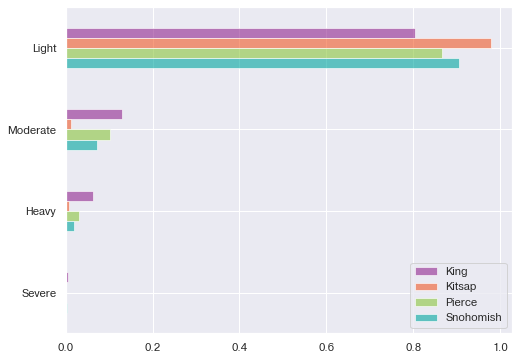

In [23]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Heavy Trucks

In [24]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='heavy_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,473,229","192,265","1,000,451","1,059,532"
Moderate,"393,536","1,578","125,951","75,724"
Heavy,"180,656",989,"37,069","15,680"
Severe,"10,281",102,"1,588","1,223"


In [25]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,80.9%,98.6%,85.9%,92.0%
Moderate,12.9%,0.8%,10.8%,6.6%
Heavy,5.9%,0.5%,3.2%,1.4%
Severe,0.3%,0.1%,0.1%,0.1%


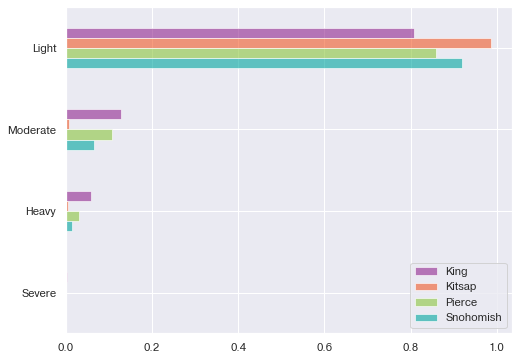

In [26]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Medium Trucks

In [27]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')

_df

county,King,Kitsap,Pierce,Snohomish
congestion_category,,,,
Severe,"16,407",201,"1,694","3,035"
Heavy,"205,877","2,322","26,075","25,693"
Moderate,"408,990","3,991","84,469","73,510"
Light,"2,510,685","232,718","779,382","808,651"


In [28]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,510,685","232,718","779,382","808,651"
Moderate,"408,990","3,991","84,469","73,510"
Heavy,"205,877","2,322","26,075","25,693"
Severe,"16,407",201,"1,694","3,035"


In [29]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,79.9%,97.3%,87.4%,88.8%
Moderate,13.0%,1.7%,9.5%,8.1%
Heavy,6.6%,1.0%,2.9%,2.8%
Severe,0.5%,0.1%,0.2%,0.3%


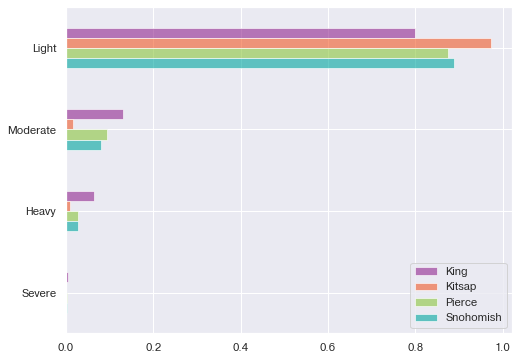

In [30]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');